In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pathlib
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout, Activation, MaxPool2D
from keras.layers.convolutional import Conv2D
from keras.models import Model,load_model
from keras.layers import Input,Dense,Flatten, merge,Lambda, LeakyReLU
from keras.layers.pooling import MaxPooling2D,AveragePooling2D,GlobalAveragePooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,Callback
from keras import backend as K
from keras.applications import Xception

In [3]:
root = '../input/image-detect'
train_path = '../input/image-detect/train'
test_path = '../input/image-detect/test'
val_path = '../input/image-detect/val/images'

In [4]:
lbl_path = '../input/image-detect/val/val_annotations.txt'
v_df = pd.read_csv(
    lbl_path, 
    sep="\t", 
    header=None)

v_df.columns=["id","label","X_min","X_max","Y_min","Y_max"]
v_df

,id,label,X_min,X_max,Y_min,Y_max
0,val_0.JPEG,n07753592,0,18,46,63
1,val_1.JPEG,n02883205,25,48,53,63
2,val_2.JPEG,n04532670,0,7,6,48
3,val_3.JPEG,n03160309,0,34,44,63
4,val_4.JPEG,n07583066,33,13,63,44
...,...,...,...,...,...,...
9995,val_9995.JPEG,n03983396,30,10,37,30
9996,val_9996.JPEG,n04596742,0,7,63,54
9997,val_9997.JPEG,n01698640,0,23,63,57
9998,val_9998.JPEG,n04074963,19,0,59,63


In [5]:
img_width, img_height = 150,150 
input_shape = (img_width, img_height, 3)
batch_size = 200

img_gen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.15,
    shear_range=0.15,
    data_format="channels_last",
    fill_mode="nearest"
)

train_dsgen = ImageDataGenerator(rescale = 1./255,horizontal_flip=True,zoom_range=0.2)

test_dsgen = ImageDataGenerator(rescale=1./255)

training_dset = img_gen.flow_from_directory(train_path,
        target_size = (img_width, img_height), 
        batch_size = batch_size,
        shuffle=True, seed=101,
        class_mode = 'categorical')

test_dset = img_gen.flow_from_directory(
        test_path,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        shuffle = False,
        class_mode = None)

val_dset = img_gen.flow_from_dataframe(
        dataframe = v_df,
        directory = val_path,
        x_col = "id",
        y_col = "label",
        shuffle=False, seed=101 ,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'categorical')

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 1 classes.
Found 10000 validated image filenames belonging to 200 classes.


In [6]:
base_model = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape)

base_model.trainable = False

inputs =Input(shape=(150, 150, 3))
x = base_model(inputs)
x.training=False

#layer1 = base_model.output
layer1 = GlobalAveragePooling2D()(x)
output = Dense(200,activation='softmax')(layer1)
model = Model(inputs = inputs, outputs=output)
base_model.trainable = True
model.summary() 

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               409800    
Total params: 21,271,280
Trainable params: 21,216,752
Non-trainable params: 54,528
_________________________________________________________________


In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,mode='auto',
                              patience=5, min_lr=0.01, cooldown=0)
losses = tf.keras.losses.CategoricalCrossentropy()
sgd = SGD(learning_rate=0.1)
model.compile(loss=losses, optimizer=sgd, metrics=['accuracy'])

In [8]:
checkpoint = ModelCheckpoint(filepath = './model.hdf5',monitor='val_accuracy', verbose=1, save_best_only=True)
 
history = model.fit_generator(
        training_dset,      
        epochs = 10,
        validation_data = val_dset,
        verbose=1,callbacks=[reduce_lr,checkpoint])

model.save('./model.hdf5')

Epoch 1/10
450/450 [==============================] - ETA: 0s - loss: 2.4667 - accuracy: 0.5252
Epoch 00001: val_accuracy improved from -inf to 0.69720, saving model to ./model.hdf5
450/450 [==============================] - 871s 2s/step - loss: 2.4667 - accuracy: 0.5252 - val_loss: 1.2782 - val_accuracy: 0.6972 - lr: 0.1000
Epoch 2/10
450/450 [==============================] - ETA: 0s - loss: 1.0511 - accuracy: 0.7420
Epoch 00002: val_accuracy improved from 0.69720 to 0.73760, saving model to ./model.hdf5
450/450 [==============================] - 768s 2s/step - loss: 1.0511 - accuracy: 0.7420 - val_loss: 1.0640 - val_accuracy: 0.7376 - lr: 0.1000
Epoch 3/10
450/450 [==============================] - ETA: 0s - loss: 0.7803 - accuracy: 0.8017
Epoch 00003: val_accuracy improved from 0.73760 to 0.74380, saving model to ./model.hdf5
450/450 [==============================] - 764s 2s/step - loss: 0.7803 - accuracy: 0.8017 - val_loss: 1.0055 - val_accuracy: 0.7438 - lr: 0.1000
Epoch 4/10
45

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.02,mode='auto',
                              patience=5, min_lr=0.01, cooldown=0)
losses = tf.keras.losses.CategoricalCrossentropy()
sgd = SGD(learning_rate=0.09)
model.compile(loss=losses, optimizer=sgd, metrics=['accuracy'])

In [13]:

checkpoint = ModelCheckpoint(filepath = './model.hdf5',monitor='val_accuracy', verbose=1, save_best_only=True)
 
history = model.fit_generator(
        training_dset,      
        epochs = 5,
        validation_data = val_dset,
        verbose=1,callbacks=[reduce_lr,checkpoint])

model.save('./model1.hdf5')

Epoch 1/5
450/450 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9753
Epoch 00001: val_accuracy improved from -inf to 0.75790, saving model to ./model.hdf5
450/450 [==============================] - 803s 2s/step - loss: 0.1006 - accuracy: 0.9753 - val_loss: 1.0776 - val_accuracy: 0.7579 - lr: 0.0900
Epoch 2/5
450/450 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9799
Epoch 00002: val_accuracy did not improve from 0.75790
450/450 [==============================] - 773s 2s/step - loss: 0.0818 - accuracy: 0.9799 - val_loss: 1.1134 - val_accuracy: 0.7568 - lr: 0.0900
Epoch 3/5
450/450 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9839
Epoch 00003: val_accuracy did not improve from 0.75790
450/450 [==============================] - 775s 2s/step - loss: 0.0670 - accuracy: 0.9839 - val_loss: 1.1350 - val_accuracy: 0.7564 - lr: 0.0900
Epoch 4/5
450/450 [==============================] - ETA: 0s - loss: 0.0551 - accura

In [14]:
model = load_model('./model1.hdf5')
test_dset.reset()
pred = model.predict_generator(test_dset,
verbose=1)

50/50 [==============================] - 74s 1s/step


In [16]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (training_dset.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [18]:
filenames = test_dset.filenames
results = pd.DataFrame({"file_name":filenames,
                      "category":predictions})
results['file_name'] = results['file_name'].map(lambda x:x.lstrip('images/'))
results.to_csv("result_img.csv",index=False)

In [21]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

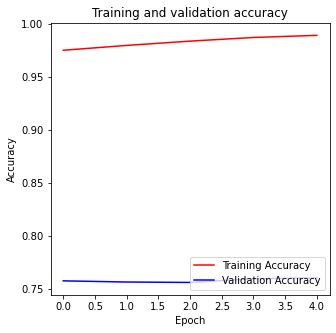

In [22]:
fig = plt.figure(figsize=(5,5))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig('11.jpg')

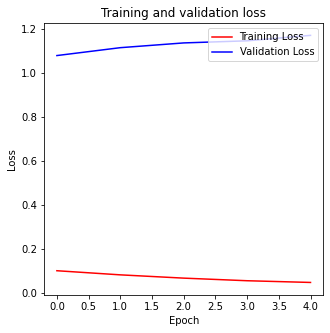

In [23]:
fig2 = plt.figure(figsize=(5,5))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.show()
fig2.savefig('12.jpg')